<a href="https://colab.research.google.com/github/Bduz/intro_pytorch/blob/main/intro_rl/NB1_Exploration_Exploitation_Bandits/NB1_Exploration_Exploitation_Bandits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1: Exploration/Exploitation in Multi-Armed Bandits

Welcome to the first notebook of the Reinforcement Learning Workshop! In this notebook, you will learn about one of the main concepts of Reinforcement Learning (RL): **Exploration and Exploitation dilemma**. You will explore this concept in a multi-armed bandit problem. Before we go into the details of the problem, let's first get familiar what exploration and exploitation mean in RL.

In RL, the agent interacts with an environment to discover a good policy. At each interaction step, the agent faces two options: **Explore** or **Exploit**. Through exploration the agent obtains more information about the environment. Through exploitation the agent exploits known information to maximise reward. Exploitation is the right thing to do maximise the expected reward on the one step, but exploitation might produce greater total reward in the long run. It is usually important to explore as well as exploit. However, it is not possible both to
explore and to exploit with any single action selection, and as such one often refers to the "conflict" or "dilemma" between exploration and exploitation.

The multi-armed bandit (also known as *k*-armed bandit) problem is an ideal environment to highlight the need to balance exploration and exploitation in reinforcement learning. A slot machine, as illustrated in Figure 1, is also known as a *one-armed bandit*. In the multi-armed bandit problem, a gambler is at a row of slot machines. The objective of the gambler is to maximize the sum of rewards earned through a sequence of arm pulls. The rules are as follows;
- Each timestep $t$ we pick a single arm to pull
- Each arm $i$ pays a reward from its distribution $p_i$ if it is played; otherwise it pays out nothing
- Each machine provides a random reward from a probability distribution specific to that machine, and the gambler doesn't know these probability distributions a-priori

<img src="https://github.com/Bduz/intro_pytorch/blob/main/intro_rl/NB1_Exploration_Exploitation_Bandits/images/slot_machines.png?raw=1" width="240" height="240" align="left" />

Figure 1: A row of slot machines in a casino

The crucial tradeoff the gambler faces at each time step is between "exploitation" of the machine that has the highest expected payoff and "exploration" to get more information about the expected payoffs of the other machines. As it is a simple and state-less problem, multi-armed bandits are a good framework to investigate the trade-off between exploration and exploitation.

In this notebook, you will use the *10-armed testbed* introduced in Section 2.3 of [1]. This testbed has 10 arms, and each arm produces a random reward from its own Gaussian distribution. The mean of each distribution is selected from a Gaussian distribution with mean 0 and variance 1. The variance of all the distributions is 1. Figure 2 shows 10 distributions for 10 arms (or actions), which is called the 10-armed testbed. After obtaining such a testbed, the performance of any learning method is measured over 1000 time steps. This makes up one run. Then the 10-armed testbed is re-initialized, and another run is carried out. After repeating this procedure multiple times, we obtain measures of the learning algorithm’s average behavior.

<img src="https://github.com/Bduz/intro_pytorch/blob/main/intro_rl/NB1_Exploration_Exploitation_Bandits/images/10armed_testbed.png?raw=1" width="680" height="500" align="left" />

Figure 2: An example bandit problem from the 10-armed testbed (taken from [1]).

In our 10-armed bandit problem, each of the 10 actions has an expected or mean reward given that that action is selected; this is called the *value* of that action (values of an example 10-armed testbed are shown in Figure 2). We denote the action selected on time step $t$ as $A_t$, and the corresponding reward as $R_t$. The value then of an arbitrary action $a$, denoted $q_*(a)$, is the expected reward given that $a$ is selected:

$${q_*}\left( a \right) \buildrel\textstyle.\over= \mathbb{E}\left[ {\left. {{R_t}} \right|{A_t} = a} \right]$$

If the gambler knew the value of each action, then it would be trivial to solve the 10-armed bandit problem: you would always select the action with highest value. We assume that the gambler does not know the action values with certainty, although he may have estimates. We denote the estimated value of action $a$ at time step $t$ as $Q_t(a)$. We would like $Q_t(a)$ to be close to $q_*(a)$. One natural way to estimate $Q_t(a)$ is by averaging the rewards actually received:

$${Q_t}\left( a \right) \buildrel\textstyle.\over= \frac{{\text{sum of rewards when $a$ taken prior to $t$}}}{{\text{number of times $a$ taken prior to $t$}}}$$

In order to calculate the estimated values of actions, we write the above equation in the incremental form. For a certain action, the new estimate for its value is calculated incrementally as follows;

$$
\begin{align}
{Q_{n + 1}} &= \frac{1}{n}\sum\limits_{i = 1}^n {{R_i}} \\
            &= {Q_n} + \frac{1}{n}\left[ {{R_n} - {Q_n}} \right], \\
\end{align}
$$

where $n$ denotes the number of times this action has been selected, $R_n$ denotes the $n$th reward, and $Q_n$ is the current estimate for the value. This update rule has a form that occurs frequently in reinforcement learning. The general form is

$$NewEstimate \leftarrow OldEstimate + StepSize\left[ {Target - OldEstimate} \right]$$

The expression $[Target−OldEstimate]$ is an error in the estimate. It is reduced by taking a step toward the "Target". The target is presumed to indicate a desirable direction in which to move. In the case above, for example, the target is the $n$th reward.

Armed with the description of the problem and the definition of the value of an action, you will now investigate the behavior of different agents in the 10-armed testbed. You will mostly focus on **Greedy** agent and **Epsilon-Greedy** agent. 

If you want to build more intuition about the trade-off between exploration and exploitation before you dive into the problem, you can play a similar game here: [Can you beat the bandit?](http://iosband.github.io/2015/07/28/Beat-the-bandit.html)

If you did not use a Jupyter notebook before, it is quite simple. Press the run button above, or shift+enter to run each of the cells. 

## Section 0: Cloning the repository

Let's first clone the repository from github:

In [5]:
!git clone https://github.com/Bduz/intro_pytorch.git

fatal: destination path 'intro_pytorch' already exists and is not an empty directory.


In [6]:
import sys
sys.path.insert(0, '/content/intro_pytorch/intro_rl/NB1_Exploration_Exploitation_Bandits')

## Section 1: Importing the necessary libraries

In [7]:
# Import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import main_agent
import ten_arm_env
from tqdm import tqdm
from rl_glue import RLGlue
from utils import argmax
import time

You start by importing the necessary libraries in the above cell. The 10-armed testbed is coded in *ten_arm_env* module. *main_agent* is the base class from which the greedy and epsilon-greey agents will inherit in the cells below. *argmax* is our own implementation of the  [argmax function](https://en.wikipedia.org/wiki/Arg_max). We will explain below why we need this implementation rather than using [Numpy's argmax function](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html). *RLGlue* is a class that organizes the communication between the agent and the environment. 

In this notebook, we will utilize the RL-Glue protocol [2]. This protocol (Figure 3) organizes the communication among the agent, the environment, the experiment, and RL-Glue. The agent implements the learning algorithm and action-selection mechanism. The environment implements the dynamics of the task and generates the observations and rewards. The experiment program directs the experiment's execution, including the sequence of agent-environment interactions and agent performance evaluation. The RL-Glue interface organizes the communication between the agent and environment in response to commands from the experiment.

<img src="https://github.com/Bduz/intro_pytorch/blob/main/intro_rl/NB1_Exploration_Exploitation_Bandits/images/rlglue_protocol.png?raw=1" width="260" height="120" align="left" />

Figure 3: RL-Glue protocol taken from [2]. Arrows indicate the direction of the flow of control.

The RL-Glue interface handles the communication between the agent and the environment as shown in Figure 4. The *rl_init* method is called when the experiment is created, and this initializes the agent and the environment. When a run is started, *rl_start* is called which first starts the environment and then the agent. Then, at each time step, *rl_step* is called which takes one environment step and one agent step.

<img src="https://github.com/Bduz/intro_pytorch/blob/main/intro_rl/NB1_Exploration_Exploitation_Bandits/images/rlglue.png?raw=1" width="720" height="420" align="left" />

Figure 4: RL-Glue class *glues* the agent and environment. 

## Section 2: Greedy Agent

The first agent you will use is **greedy** agent. This agent follows a pure exploitation strategy. Since the agent maintains estimates of the action values, then at any time step there is at least one action whose estimated value is greatest. We call these the greedy actions, and the agent which always chooses the greedy action is called the greedy agent. When the agent selects one of these actions, it is exploiting its current knowledge of the values of the actions. Pseudocode of the algorithm with the greedy agent is given below. Let's look at what happens in this case.

<img src="https://github.com/Bduz/intro_pytorch/blob/main/intro_rl/NB1_Exploration_Exploitation_Bandits/images/bandit_algorithm_greedy.png?raw=1" width="660" height="300" align="left" />

Below the greedy agent class (GreedyAgent) is shown. This class inherits from the *Agent* class, and only reimplements the *agent_step* method. This method gets called each time the agent takes a step. The method has to return the action selected by the agent. This method also ensures the agent’s estimates are updated based on the reward it gets from the environment. This method simply implements the algorithm given in pseudocode above.   
Note that we are using our own argmax function, which takes in a list of action values and returns an action with the highest value. Why are we implementing our own instead of using the argmax function that numpy uses? Numpy's argmax function returns the first instance of the highest value. We do not want that to happen as it biases the agent to choose a specific action in the case of ties. Instead we want to break ties between the highest values randomly. 

In [8]:
class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in. 
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        ### Useful Class Variables ###
        # self.q_values : An array with the agent’s value estimates for each action.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step.
        #######################
        current_action = argmax(self.q_values)
        # Update action values using the pseudocode above.
        # Increment the counter in self.arm_count for the action from the previous time step
        # Update the step size using self.arm_count
        # Update self.q_values for the action from the previous time step
        self.arm_count[self.last_action] += 1
        step_size = self.arm_count[self.last_action]
        self.q_values[self.last_action] += (reward-self.q_values[self.last_action])/step_size
        self.last_action = current_action
        
        return current_action

Let's now run an experiment to measure the performance of the greedy agent, and then visualize the results.

100%|██████████| 200/200 [00:07<00:00, 28.36it/s]


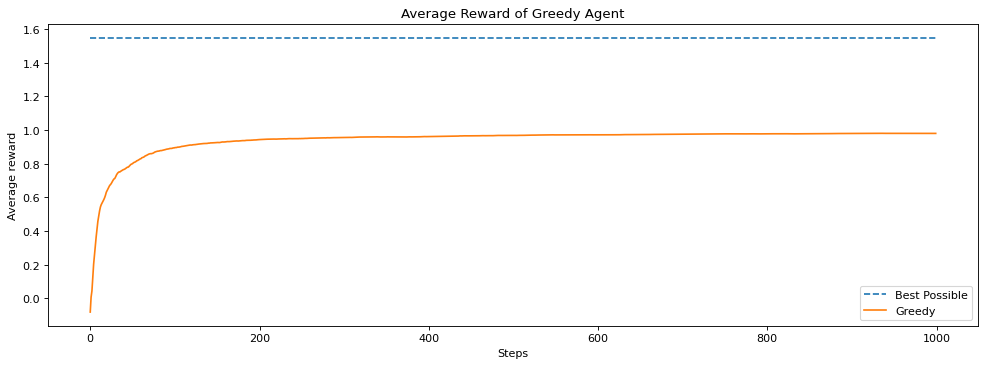

In [9]:
# Plot Greedy Result
num_runs = 200                    # The number of times we run the experiment
num_steps = 1000                  # The number of steps each experiment is run for
env = ten_arm_env.Environment     # We the environment to use
agent = GreedyAgent               # We choose what agent we want to use
agent_info = {"num_actions": 10}  # Pass the agent the information it needs; 
                                  # here it just needs the number of actions (number of arms).
env_info = {}                     # Pass the environment the information it needs; in this case, it is nothing.

all_averages = []

for i in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below once the code is run
    rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
    rl_glue.rl_init(agent_info, env_info) # Pass RLGlue what it needs to initialize the agent and environment
    rl_glue.rl_start()                    # Start the experiment

    scores = [0]
    averages = []
    
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)

How did the greedy agent do? Is it possible for it to do better?

## Section 3: Epsilon-Greedy Agent

The second agent you will use is the **epsilon-greedy** ($\varepsilon$-greedy) agent. Instead of behaving greedily all the time, the $\varepsilon$-greedy agent behaves greedily most of the time. Every once in a while, say with small probability $\varepsilon$, it selects randomly from among all the actions with equal probability. In all the other times, with probability 1 - $\varepsilon$, it selects the greedy action. This near-greedy action selection rule is called $\varepsilon$-greedy methods. An advantage of these methods is that, in the limit as the number of steps increases, every action will be sampled an infinite number of times, thus ensuring that all the $Q_t(a)$ converge to $q_*(a)$. Pseudocode of the algorithm with the $\varepsilon$-greedy agent is given below. Let's run an experiment with this agent, and compare its performance to the greedy agent's performance.

<img src="https://github.com/Bduz/intro_pytorch/blob/main/intro_rl/NB1_Exploration_Exploitation_Bandits/images/bandit_algorithm_epsilongreedy.png?raw=1" width="660" height="300" align="left" />

Below the $\varepsilon$-greedy agent class (EpsilonGreedyAgent) is shown. Similar to the greedy agent above, this class inherits from the *Agent* class, and only reimplements the *agent_step* method. This method simply implements the algorithm given in pseudocode above.

In [10]:
class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this for this assignment 
        as you will not use it until future lessons.
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        ### Useful Class Variables ###
        # self.q_values : An array with the agent’s value estimates for each action.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step.
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        #######################
        
        # Choose action using epsilon-greedy
        # Randomly choose a number between 0 and 1 and see if it is less than self.epsilon
        # If it is, set current_action to a random action.
        # Otherwise choose current_action greedily as you did above.

        if np.random.random() < self.epsilon:
            current_action = np.random.randint(0, len(self.q_values))
        else:
            current_action = argmax(self.q_values)
     
        # Update action-values - this should be the same update as the greedy-agent above
        self.arm_count[self.last_action] += 1
        step_size = self.arm_count[self.last_action]
        self.q_values[self.last_action] += (reward-self.q_values[self.last_action])/step_size        
        self.last_action = current_action
        
        return current_action

Let's run an experiment with the $\varepsilon$-greedy agent with $\varepsilon  = 0.1$.

100%|██████████| 200/200 [00:07<00:00, 27.97it/s]


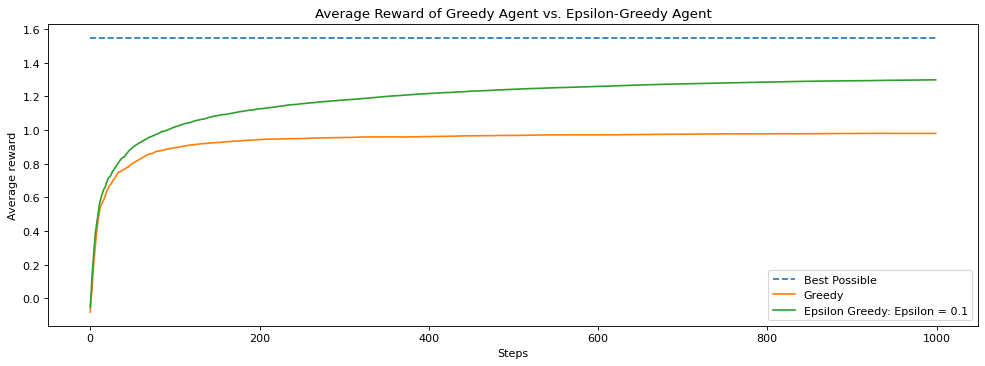

In [11]:
num_runs = 200
num_steps = 1000
epsilon = 0.1
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": epsilon}
env_info = {}
all_averages = []

for i in tqdm(range(num_runs)):
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    averages = []
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.title("Average Reward of Greedy Agent vs. Epsilon-Greedy Agent")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(("Best Possible", "Greedy", "Epsilon Greedy: Epsilon = 0.1"))
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

Notice how much better the epsilon-greedy agent did. Because we occasionally choose a random action we were able to find a better long term policy. By acting greedily before our value estimates are accurate, we risk settling on a suboptimal action.

## Section 4: Comparing Values of Epsilon

Can you do better than an epsilon of 0.1? Let's try several different values for epsilon and see how they perform. We try different settings of key performance parameters to understand how the agent might perform under different conditions.

Below we run an experiment where we sweep over different values for epsilon:

100%|██████████| 200/200 [00:06<00:00, 28.61it/s]


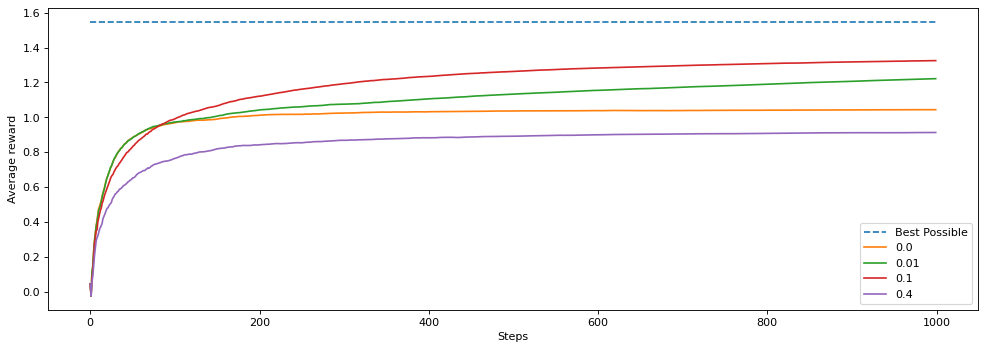

In [12]:
# Experiment code for epsilon-greedy with different values of epsilon
epsilons = [0.0, 0.01, 0.1, 0.4]

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

n_q_values = []
n_averages = []
n_best_actions = []

num_runs = 200

for epsilon in epsilons:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        best_action_chosen = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if epsilon == 0.1 and run == 0:
                n_q_values.append(np.copy(rl_glue.agent.q_values))
        if epsilon == 0.1:
            n_averages.append(averages)
            n_best_actions.append(best_action_chosen)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible"] + epsilons)
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

Why did 0.1 perform better than 0.01?

If exploration helps why did 0.4 perform worse than 0.0 (the greedy agent)?

## Section 5: The Effect of the Step Size

So far we decayed the step size over time based on action-selection counts. The step-size was $1/N(A)$, where $N(A)$ is the number of times action $A$ was selected. This is the same as computing a sample average. We could also set the step size to be a constant value, such as 0.1. What would be the effect of doing that? And is it better to use a constant or the sample average method? 

To investigate this question, let’s start by creating a new agent that has a constant step size. This will be nearly identical to the agent created above. You will use the same code to select the epsilon-greedy action. The only change is that the error is multiplied by a constant step size instead of $1/N(A)$.

In [13]:
class EpsilonGreedyAgentConstantStepsize(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this for this assignment 
        as you will not use it until future lessons.
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        ### Useful Class Variables ###
        # self.q_values : An array with the agent’s value estimates for each action.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step.
        # self.step_size : A float which is the current step size for the agent.
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        #######################
        
        # Choose action using epsilon greedy. This is the same as you implemented above.
        if np.random.random() < self.epsilon:
            current_action = np.random.randint(0, len(self.q_values))
        else:
            current_action = argmax(self.q_values)
       
        # Update q_values for action taken at previous time step using self.step_size intead of using self.arm_count
        self.arm_count[self.last_action] += 1
        self.q_values[self.last_action] += self.step_size * (reward-self.q_values[self.last_action])
        self.last_action = current_action
        
        return current_action

Lets's run experiments with various step sizes, and compare the results.

100%|██████████| 200/200 [00:07<00:00, 27.35it/s]


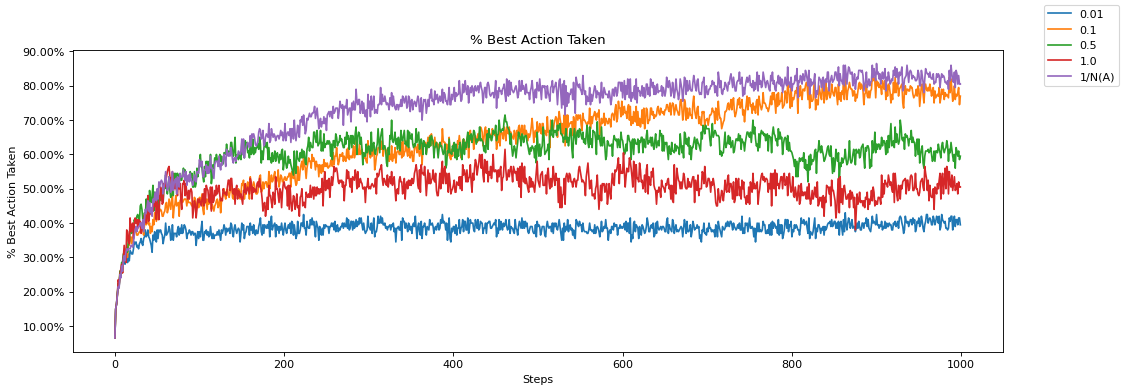

In [14]:
step_sizes = [0.01, 0.1, 0.5, 1.0]

epsilon = 0.1
num_steps = 1000
num_runs = 200

fig, ax = plt.subplots(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

q_values = {step_size: [] for step_size in step_sizes}
true_values = {step_size: None for step_size in step_sizes}
best_actions = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgentConstantStepsize
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size, "initial_value": 0.0}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        
        if run == 0:
            true_values[step_size] = np.copy(rl_glue.environment.arms)
            
        best_action_chosen = []
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if run == 0:
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))
        best_actions[step_size].append(best_action_chosen)
    ax.plot(np.mean(best_actions[step_size], axis=0))
    
ax.plot(np.mean(n_best_actions, axis=0))
fig.legend(step_sizes + ["1/N(A)"])
plt.title("% Best Action Taken")
plt.xlabel("Steps")
plt.ylabel("% Best Action Taken")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

Notice first that we are now plotting the amount of time that the best action is taken rather than the average reward. To better  understand the performance of an agent, it can be useful to measure specific behaviors, beyond just how much reward is accumulated. This measure indicates how close the agent’s behaviour is to optimal.

It seems as though $1/N(A)$ performed better than the others, in that it reaches a solution where it takes the best action most frequently. Now why might this be? Why did a step size of 0.5 start out better but end up performing worse? Why did a step size of 0.01 perform so poorly?

Let's dig into this further below. Let’s plot how well each agent tracks the true value, where each agent has a different step size method. 

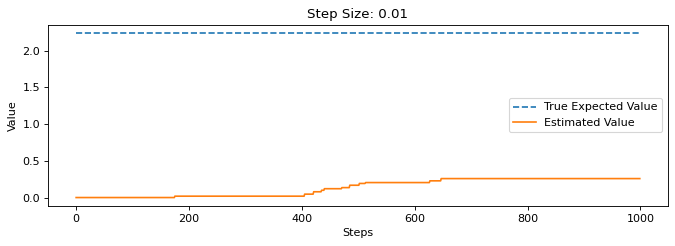

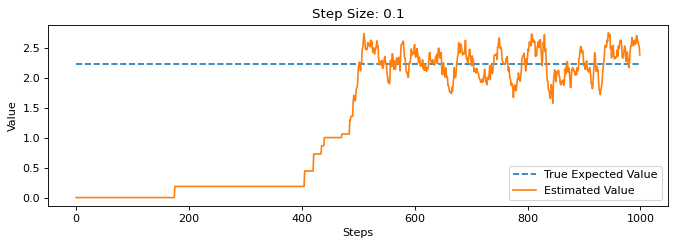

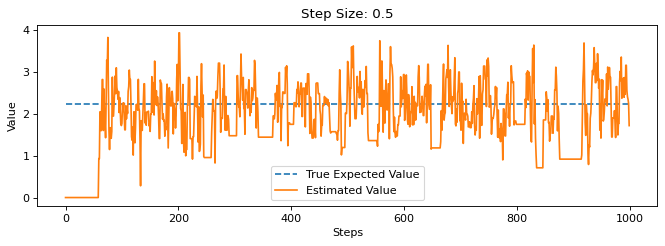

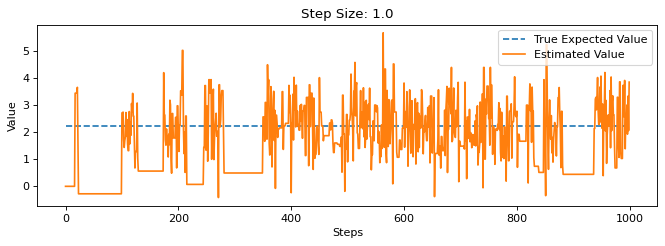

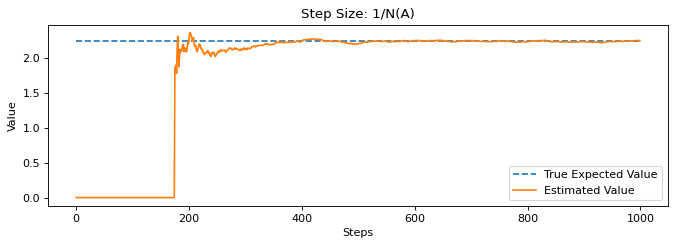

In [15]:
# Plot various step sizes and estimates
largest = 0
num_steps = 1000
for step_size in step_sizes:
    plt.figure(figsize=(10, 3), dpi= 80, facecolor='w', edgecolor='k')
    largest = np.argmax(true_values[step_size])
    plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
    plt.title("Step Size: {}".format(step_size))
    plt.plot(np.array(q_values[step_size])[:, largest])
    plt.legend(["True Expected Value", "Estimated Value"])
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.show()

plt.figure(figsize=(10, 3), dpi= 80, facecolor='w', edgecolor='k')
plt.title("Step Size: 1/N(A)")
plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
plt.plot(np.array(n_q_values)[:, largest])
plt.legend(["True Expected Value", "Estimated Value"])
plt.xlabel("Steps")
plt.ylabel("Value")
plt.show()

These plots help clarify the performance differences between the different step sizes. A step size of 0.01 makes such small updates that the agent’s value estimate of the best action does not get close to the actual value. Step sizes of 0.5 and 1.0 both get close to the true value quickly, but are very susceptible to stochasticity in the rewards. The updates overcorrect too much towards recent rewards, and so oscillate around the true value. This means that on many steps, the action that pulls the best arm may seem worse than it actually is.  A step size of 0.1 updates fairly quickly to the true value, and does not oscillate as widely around the true values as 0.5 and 1.0. This is one of the reasons that 0.1 performs quite well. Finally we see why $1/N(A)$ performed well. Early on while the step size is still reasonably high it moves quickly to the true expected value, but as it gets pulled more its step size is reduced which makes it less susceptible to the stochasticity of the rewards.

## Section 6: Non-stationary environments
So far, you observed that $1/N(A)$ performs quite well. Does this mean that $1/N(A)$ is always the best? When might it not be? One possible setting where it might not be as effective is in non-stationary problems. Non-stationarity means that the environment may change over time. This could manifest itself as continual change over time of the environment, or a sudden change in the environment.

Let's look at how a sudden change in the reward distributions affects a step size like $1/N(A)$. This time we will run the environment for 2000 steps, and after 1000 steps we will randomly change the expected value of all of the arms. We compare two agents, both using epsilon-greedy with epsilon = 0.1. One uses a constant step size of 0.1, the other a step size of $1/N(A)$ that reduces over time.

100%|██████████| 200/200 [00:14<00:00, 14.27it/s]


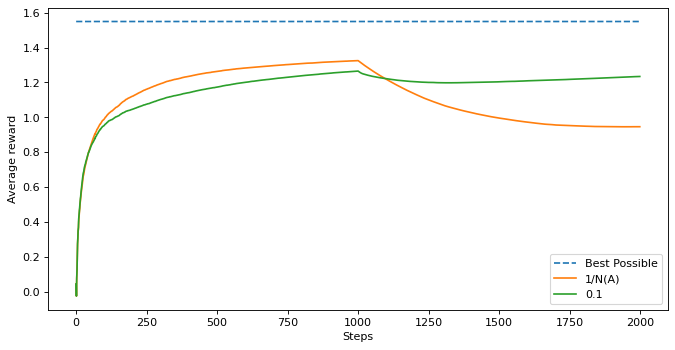

In [16]:
epsilon = 0.1
num_steps = 2000
num_runs = 200
step_size = 0.1

plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

for agent in [EpsilonGreedyAgent, EpsilonGreedyAgentConstantStepsize]:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        scores = [0]
        averages = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if i == 1000:
                rl_glue.environment.arms = np.random.randn(10)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible", "1/N(A)", "0.1"])
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

Now the agent with a step size of $1/N(A)$ performed better at the start but then performed worse when the environment changed! What happened?

Think about what the step size would be after 1000 steps. Let's say the best action gets chosen 500 times. That means the step size for that action is 1/500 or 0.002. At each step when we update the value of the action and the value is going to move only 0.002 * the error. That is a very tiny adjustment and it will take a long time for it to get to the true value.

The agent with step size 0.1, however, will always update in 1/10th of the direction of the error. This means that on average it will take ten steps for it to update its value to the sample mean.

These are the types of tradeoffs we have to think about in reinforcement learning. A larger step size moves us more quickly toward the true value, but can make our estimated values oscillate around the expected value. A step size that reduces over time can converge to close to the expected value, without oscillating. On the other hand, such a decaying stepsize is not able to adapt to changes in the environment. Nonstationarity, and the related concept of partial observability, is a common feature of reinforcement learning problems and when learning online.

## Section 7: Conclusions
Congratulations, you finished the first notebook in the RL workshop! You have:
- Learned about the bandit problem, and investigated the trade-off between exploration and exploitation
- Learned about the effect of epsilon, an exploration parameter, on the performance of an agent
- Learned about the effect of step size on the performance of the agent
- Learned about how different update rules perform in non-stationary environments

## Section 8: Challenges

Would you like to enhance your knowledge on the topic of this notebook? Then these challenges are good to start with:
- Why did we follow the practice of averaging across multiple runs? Can you show the results of the same epsilon-greedy agent from two runs with different seeds (Hint: Look at *numpy.random.seed*)? Can you explain why the results are different?
- Some more advanced algorithms are mentioned [here](http://iosband.github.io/2015/07/19/Efficient-experimentation-and-multi-armed-bandits.html). Can you implement one of these, and compare your results to the greedy and epsilon-greedy agents?

## References
[1] R. S. Sutton and A. G. Barto, "Reinforcement Learning", MIT Press, 2018.   
[2] B. Tanner and A. White, "RL-Glue: Language-Independent Software for Reinforcement-Learning Experiments", Journal of Machine Learning Research, 10:2133-2136, 2009.